#Introduction

### This notebook will investigate the warming of the sea surface temperature of the Arctic Ocean, and forecast it into the future

#Data

 The data was taken from ERA5 at
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview, which is created by the European Center for Medium-Range Weather Forecasting.


# Data Preparation

#### Install package for Prophet Model Forecasting

In [19]:
!pip install prophet

Load relevant packages

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import median_filter

#### Load CSV, set reshaped variables to use in Time Series Forecasting

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/arctic.csv")
temp = df["sst"].values.reshape(-1, 1)
wave = df["hsig"].values.reshape(-1, 1)
wind = df["u10"].values.reshape(-1, 1)
time = np.arange(len(df))

#### Create date column for later visuals

In [22]:
start_date = '1940-01-01'

date_list = pd.date_range(start=start_date, periods=len(time), freq='D')

df['date'] = date_list

#### Inspect contents of data frame

In [23]:
df.describe()

,sst,u10,hsig,latitude,longitude,date
count,30747.000000,30747.000000,6123.000000,30747.0,3.074700e+04,30747
mean,272.257327,-1.632012,0.846164,70.0,-1.401000e+02,1982-02-02 00:00:00
min,271.428220,-18.460785,0.038730,70.0,-1.401000e+02,1940-01-01 00:00:00
25%,271.459960,-6.567221,0.433221,70.0,-1.401000e+02,1961-01-16 12:00:00
50%,271.460170,-2.435123,0.708456,70.0,-1.401000e+02,1982-02-02 00:00:00
75%,271.472930,3.131529,1.123738,70.0,-1.401000e+02,2003-02-18 12:00:00
max,284.926760,29.079378,5.937017,70.0,-1.401000e+02,2024-03-06 00:00:00
std,1.922779,6.354461,0.566013,0.0,2.842217e-14,NaN


#### For this investigation, we will solely use the Sea Surface Temperature (sst) and date columns.

## First, we will graph the mean surface temperature by year on a lineplot to see if there is any clear trend before using more advanced forecasting methods

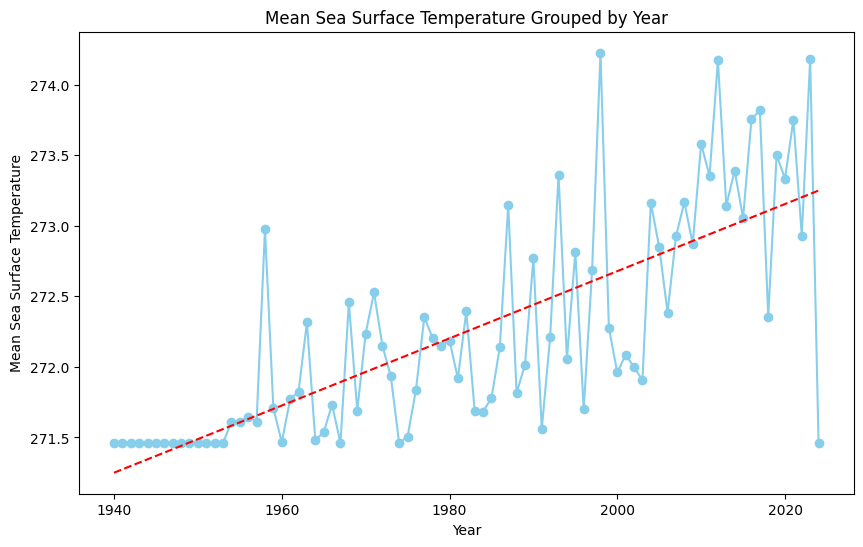

In [24]:
df['year'] = df['date'].dt.year

mean_temp_by_year = df.groupby('year')['sst'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mean_temp_by_year.index, mean_temp_by_year, marker='o', linestyle='-', color='skyblue')

ax.set_xlabel('Year')
ax.set_ylabel('Mean Sea Surface Temperature')
ax.set_title('Mean Sea Surface Temperature Grouped by Year')

z = np.polyfit(mean_temp_by_year.index, mean_temp_by_year, 1)
p = np.poly1d(z)
ax.plot(mean_temp_by_year.index, p(mean_temp_by_year.index), "r--")

plt.show()

### A clear upwards trend presents itself, showing how the Arctic Ocean has been warming from 1940 to 2024, albeit with significant variation year to year.

#### To emphasize this point, we will look at the top 10 warmest years and top 10 coldest years.

In [25]:
median_sst_by_year = df.groupby('year')['sst'].median()

sorted_years = median_sst_by_year.sort_values()

print("Top 10 Hottest Median Years:")
print(sorted_years.tail(10))

print("\nTop 10 Lowest Median Years:")
print(sorted_years.head(10))

Top 10 Hottest Median Years:
year
1993    271.460360
1996    271.460360
1988    271.460360
1982    271.460360
1998    271.460800
2015    271.460800
2007    271.460800
2021    271.462830
2019    271.470900
2016    272.065125
Name: sst, dtype: float64

Top 10 Lowest Median Years:
year
1967    271.45996
1940    271.46017
1968    271.46017
1969    271.46017
1970    271.46017
1971    271.46017
1972    271.46017
1973    271.46017
1974    271.46017
1975    271.46017
Name: sst, dtype: float64


#### Of the top 10 warmest months, half of them occoured after the year 2000. Meanwhile no post-2000 year shows up in the list of the 10 lowest median surface temperature years.

### Now, we will look at histograms to see how the distribution of Sea Surface Temperature has changed from decade to decade. The vast majority of days see a sea surface temperature at around 272. To make the histograms easier to read, we will only include days where the temperature was above 272, while including a statistic showing what percentage of days in each decade saw a temperature above 272. This stat is located in the upper right hand corner.

<ipython-input-26-769c85a7787d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high['decade'] = (df_high['date'].dt.year // 10) * 10


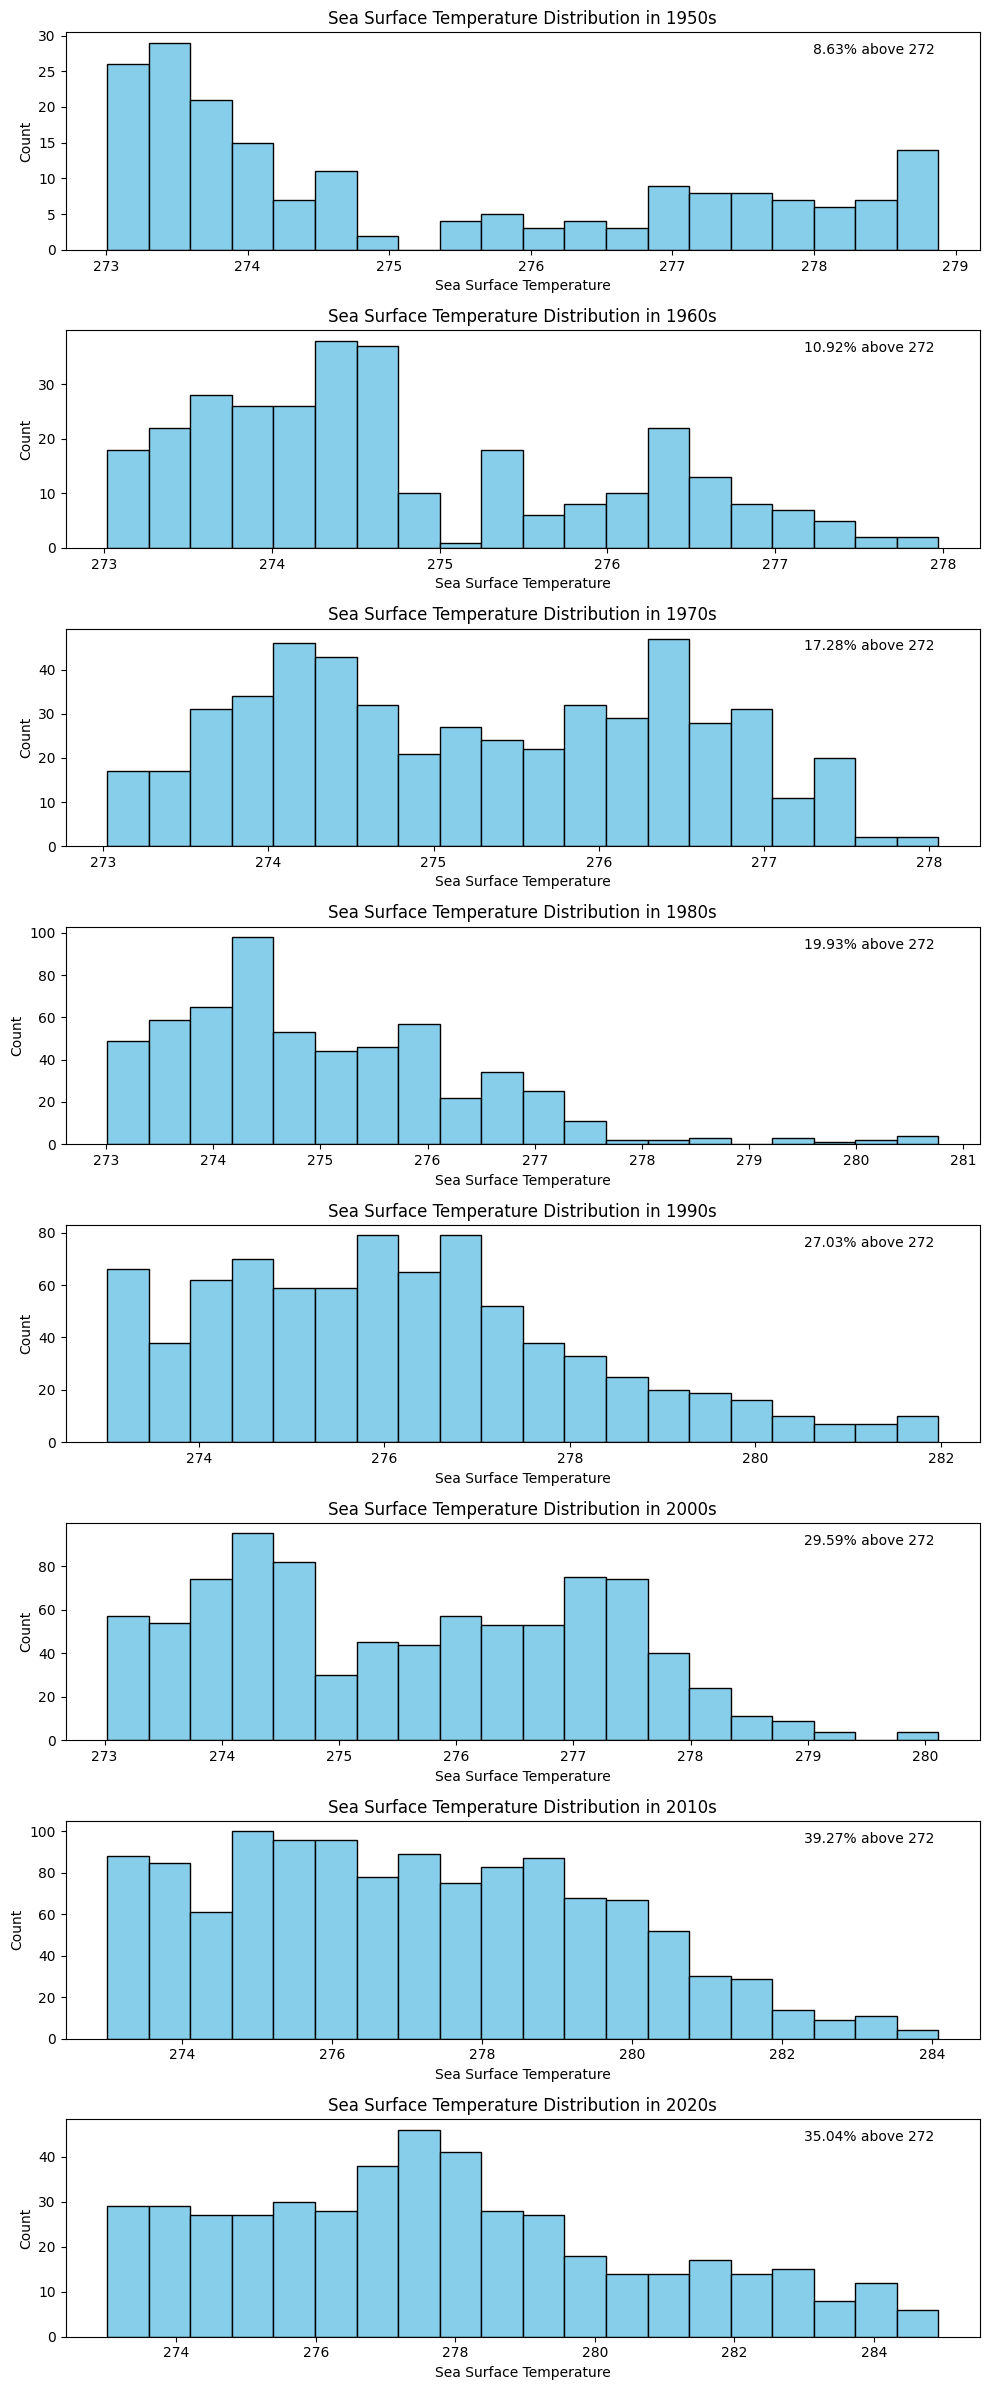

In [26]:
#Create lists and dictionaries to use in visuals
df['decade'] = (df['date'].dt.year // 10) * 10
per_list = []
decades = sorted(df['decade'].unique())
per_dict = {}

for decade in decades:
    data = df[df['decade'] == decade]
    percentage_above_272 = (data['sst'] > 272).mean() * 100
    per_list.append(percentage_above_272)
    per_dict[decade] = percentage_above_272

df_high = df[df['sst'] >= 273]

df['decade'] = (df['date'].dt.year // 10) * 10

df_high['decade'] = (df_high['date'].dt.year // 10) * 10

decades = df_high['decade'].unique()

fig, axes = plt.subplots(nrows=len(decades), ncols=1, figsize=(10, len(decades) * 3))
count = 1
for i, decade in enumerate(sorted(decades)):
    ax = axes[i]
    data = df_high[df_high['decade'] == decade]
    ax.hist(data['sst'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Sea Surface Temperature Distribution in {decade}s')
    ax.set_xlabel('Sea Surface Temperature')
    ax.set_ylabel('Count')

    percentage_above_272 = per_list[count]
    ax.text(0.95, 0.95, f'{percentage_above_272:.2f}% above 272',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, color='black', fontsize=10)
    count +=1


plt.tight_layout()
plt.show()

Not only has the share of days with sea surface temperature above 272 degrees Kelvin increased, but there are also significantly more days which are >280 degrees Kelvin in the later decades.

#### A clear trend presents itself, with the Arctic Ocean being over three times as likely to have a surface temperature over 272 degrees Kelvin in the 2020s than in the 1950s. To visually demonstrate this, a line plot is presented below

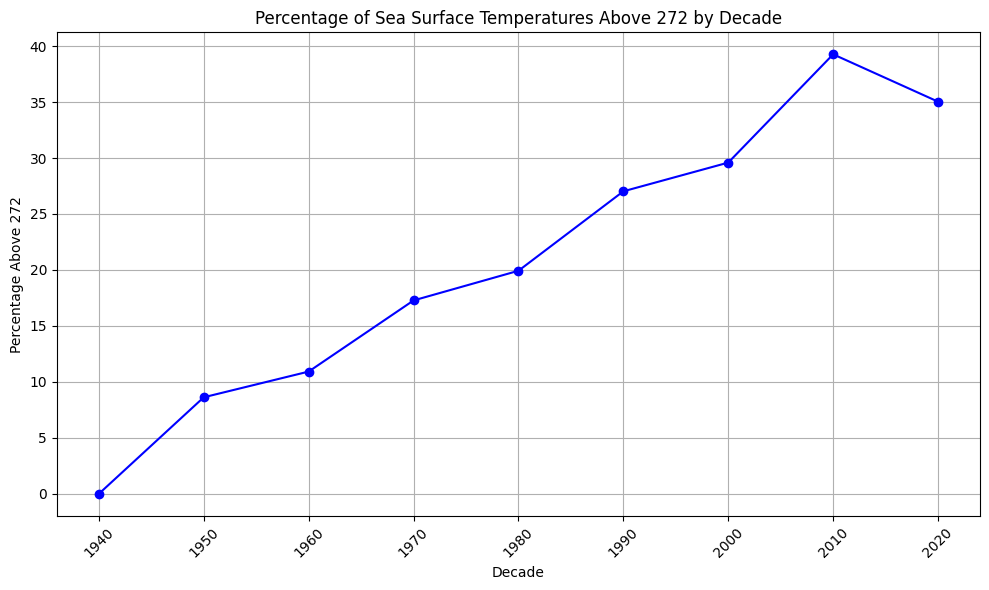

In [27]:


decades = sorted(per_dict.keys())
percentages = [per_dict[decade] for decade in decades]

plt.figure(figsize=(10, 6))
plt.plot(decades, percentages, marker='o', linestyle='-', color='b')

plt.title('Percentage of Sea Surface Temperatures Above 272 by Decade')
plt.xlabel('Decade')
plt.ylabel('Percentage Above 272')
plt.grid(True)
plt.xticks(decades, rotation=45)

plt.tight_layout()
plt.show()

#### As mentioned before, there is a clear upwards warming trend in the Arctic Ocean as each decade sees a higher percentage of days with a sea surface temperature above 272


# Forecasting

## First, we will use a one year moving average to highlight additional trends in the data set before beginning our forecast

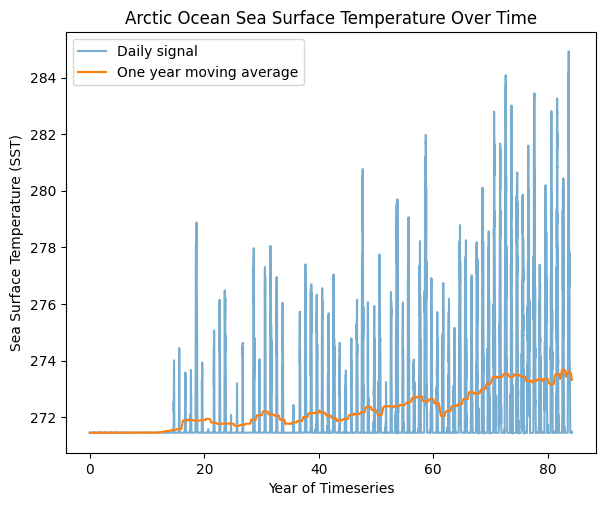

In [28]:
sst = df["sst"].values
t = np.arange(len(sst))

window_len = 365 * 5
sst_ma = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Sea Surface Temperature (SST)")
ax.set_title("Arctic Ocean Sea Surface Temperature Over Time")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

### The above visual demonstrates that there is a cyclical nature to the SST of the Arctic Ocean, with each cycle lasting roughly 9 years. In the long-term, the SST trends upwards as demonstrated in previous visualizations.

### The Prophet model

#### Next, we will use a Prophet model to forecast what the SST of the Arctic Ocean will be 28 years from now. A seasonality of 9 years will be used to account for the aformentioned cyclical trend.  The data frame will be fit over 10 year intervals to more accurately model the long-term warming trend.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/j96lcsgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/k7n9cifp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90464', 'data', 'file=/tmp/tmp6tm4h1fp/j96lcsgl.json', 'init=/tmp/tmp6tm4h1fp/k7n9cifp.json', 'output', 'file=/tmp/tmp6tm4h1fp/prophet_modelwy59s_kw/prophet_model-20240521061512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


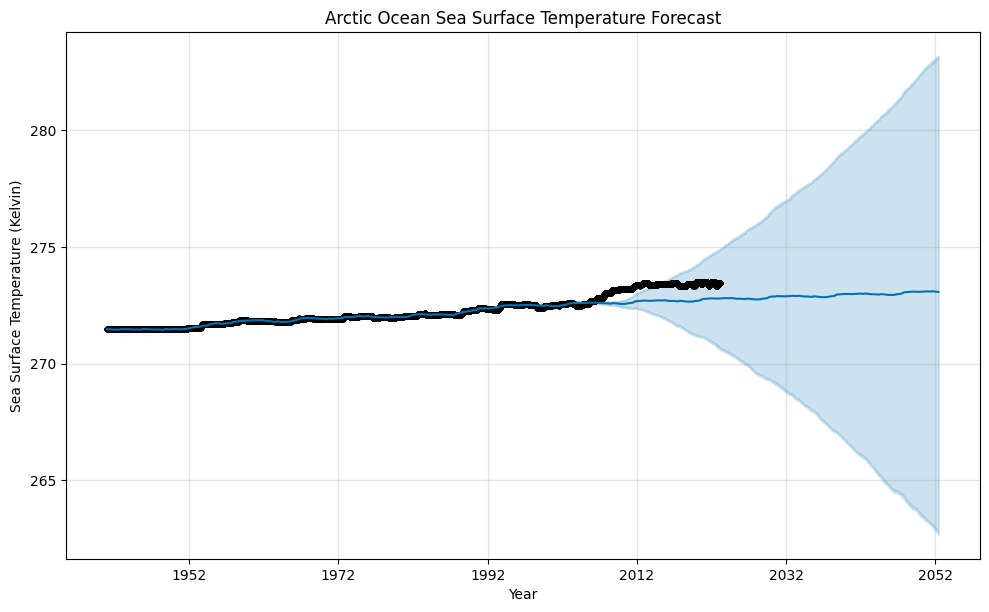

In [29]:
from prophet import Prophet

k = 356*30
df_fit = pd.DataFrame()
df_fit["ds"] = pd.to_datetime(df["time"])
df_fit["y"] = uniform_filter1d(df["sst"], 365 * 10)
df_fit = df_fit.iloc[365 * 1:-365 * 1, :].reset_index(drop=True)

train_indices = list(range(8 * len(df_fit) // 10))
test_indices = list(range(8 * len(df_fit) // 10, len(df_fit)))
df_train = df_fit.loc[train_indices]
df_test = df_fit.loc[test_indices]


m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.add_seasonality(name='9yr', period=365 * 9, fourier_order=32)
m.fit(df_train)
future = m.make_future_dataframe(periods=len(df_test) + k, freq="1D")
forecast = m.predict(future)

fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_xlabel("Year")
ax.set_ylabel("Sea Surface Temperature (Kelvin)")
ax.set_title("Arctic Ocean Sea Surface Temperature Forecast")
ax.plot(df_test["ds"], df_test["y"], 'ko', markersize=3)

#### The Prophet model predicts a steady albeit slow increase in SST into 2052. It also predicts that the temperature will stay more or less stagnant year to year, but will experience slight temperature increases roughly every 9 years.


### The predictions for sst in future years from the above Prophet model are listed below:

In [30]:
forecast["year"] = forecast["ds"].dt.year
future_predictions = forecast[(forecast["year"] >= 2025) & (forecast["year"] <= 2052)]

yearly_predictions = future_predictions.groupby("year")["yhat"].mean().reset_index()
yearly_predictions.rename(columns={"yhat": "predicted SST"}, inplace=True)

print(yearly_predictions)

    year  predicted SST
0   2025     272.777352
1   2026     272.766315
2   2027     272.754341
3   2028     272.753701
4   2029     272.815738
5   2030     272.874114
6   2031     272.880079
7   2032     272.886455
8   2033     272.893075
9   2034     272.873161
10  2035     272.862267
11  2036     272.850049
12  2037     272.849867
13  2038     272.912127
14  2039     272.970144
15  2040     272.975971
16  2041     272.982503
17  2042     272.988942
18  2043     272.968970
19  2044     272.958235
20  2045     272.945746
21  2046     272.945998
22  2047     273.008517
23  2048     273.066194
24  2049     273.071866
25  2050     273.078526
26  2051     273.084808
27  2052     273.069636


# Conclusion

#### The Arctic ocean has consistently warmed over the last 80 years. Our model predicts that the sst of the arctic Ocean will increase by ~0.4 degrees Kelvin from 2024 to 2052.




# Additional Question:

## How has the temperature increase in the Arctic Ocean impacted the percentage of time its temperature is below freezing?

#### First, we will set a variable freezing_point at 273.15 degrees Kelvin, which is the freezing point of water. It should be noted that the Arctic Ocean does not completely freeze at this temperature due to its salty composition.

In [31]:
freezing_point = 273.15

#### Next, we will look at what percentage of days the Arctic Ocean has been below Freezing temperature, grouped by year. To do this we will create a new boolean field called 'below_freezing to use for our calculations and visualizations. We will then use this field to create a line plot to view the historical data at a glance.

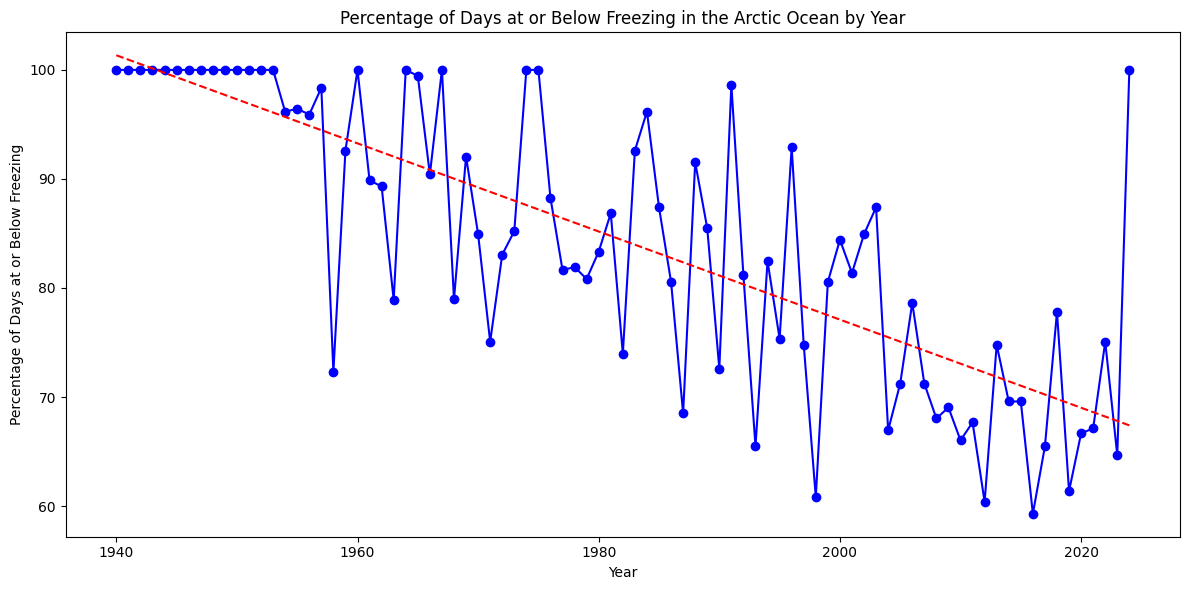

In [32]:
df['below_freezing'] = df['sst'] <= freezing_point

df['year'] = df['date'].dt.year

percentage_below_freezing_by_year = df.groupby('year')['below_freezing'].mean() * 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(percentage_below_freezing_by_year.index, percentage_below_freezing_by_year, marker='o', linestyle='-', color='blue')

z = np.polyfit(percentage_below_freezing_by_year.index, percentage_below_freezing_by_year, 1)
p = np.poly1d(z)
ax.plot(percentage_below_freezing_by_year.index, p(percentage_below_freezing_by_year.index), "r--")


ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Days at or Below Freezing')
ax.set_title('Percentage of Days at or Below Freezing in the Arctic Ocean by Year')

plt.tight_layout()
plt.show()

#### There is a clear downwards trend to the percentage of days which see the Arctic Ocean's sst below freezing. From 1940 through much of the 1950s the entire year would see the SST below freezing, while the 2020s saw SST dipping below freezing only 60-70% of the time

#### Now, we will reshape the dataframe to use in our prophet model. We will also cast the boolean field as an integer, which is required for our calculations.

In [33]:
freeze = df["below_freezing"].values.reshape(-1, 1)
df['below_freezing'] = (df['sst'] <= freezing_point).astype(int)

#### This prophet model uses similar to that used for our initial research question, albeit without smoothing (smoothing is not effective at improving this visualization due to the binary nature of the measured variable).

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/ug44og4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/a7g963bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62994', 'data', 'file=/tmp/tmp6tm4h1fp/ug44og4m.json', 'init=/tmp/tmp6tm4h1fp/a7g963bq.json', 'output', 'file=/tmp/tmp6tm4h1fp/prophet_modelner8sj29/prophet_model-20240521061725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/5l9jt6_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tm4h1fp/a_xxct1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

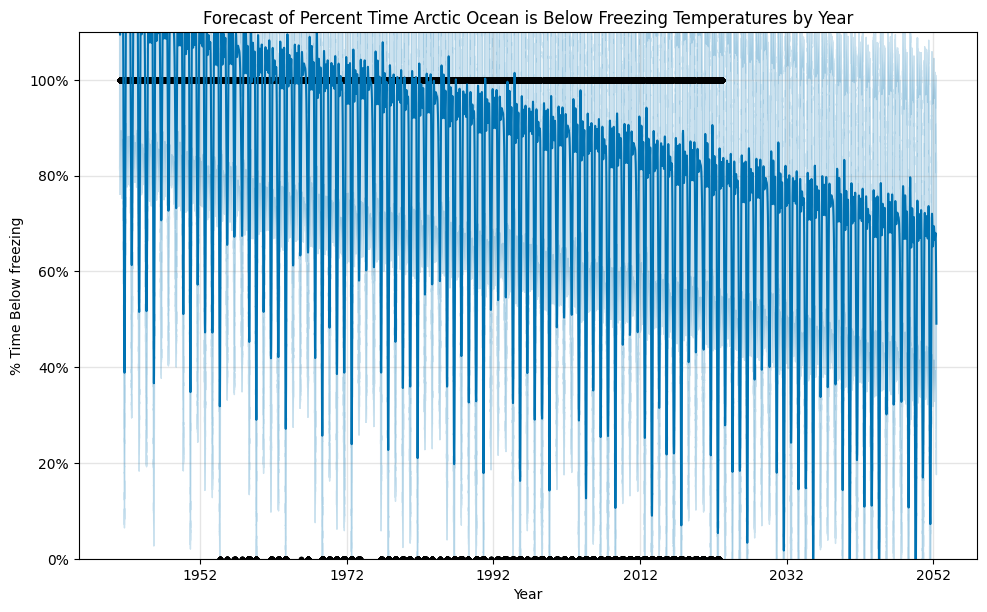

In [34]:
import matplotlib.ticker as mticker
k = 356*30
df_fit = pd.DataFrame()
df_fit["ds"] = pd.to_datetime(df["time"])
df_fit["y"] = uniform_filter1d(df["below_freezing"], 365 * 10)
df_fit = df_fit.iloc[365 * 1:-365 * 1, :].reset_index(drop=True)

train_indices = list(range(8 * len(df_fit) // 10))
test_indices = list(range(8 * len(df_fit) // 10, len(df_fit)))
df_train = df_fit.loc[train_indices]
df_test = df_fit.loc[test_indices]

m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)

m.add_seasonality(name='9yr', period=365 * 9, fourier_order=32)
m.fit(df_train)
future = m.make_future_dataframe(periods=len(df_test) + k, freq="1D")
forecast = m.predict(future)

df_fit = pd.DataFrame()
df_fit["ds"] = pd.to_datetime(df["time"])
df_fit["y"] = df["below_freezing"]


df_fit = df_fit.iloc[365 * 1:-365 * 1, :].reset_index(drop=True)

train_indices = list(range(8 * len(df_fit) // 10))
test_indices = list(range(8 * len(df_fit) // 10, len(df_fit)))
df_train = df_fit.loc[train_indices]
df_test = df_fit.loc[test_indices]

m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.add_seasonality(name='9yr', period=365 * 9, fourier_order=32)
m.fit(df_train)

future = m.make_future_dataframe(periods=len(df_test) + k, freq="1D")
forecast = m.predict(future)

forecast["year"] = forecast["ds"].dt.year
future_predictions = forecast[(forecast["year"] >= 2025) & (forecast["year"] <= 2052)]

fig1 = m.plot(forecast)
ax = fig1.gca()
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
ax.set_ylim(0, 1.1)
ax.set_xlabel("Year")
ax.set_ylabel("% Time Below freezing")
ax.set_title("Forecast of Percent Time Arctic Ocean is Below Freezing Temperatures by Year")
ax.plot(df_test["ds"], df_test["y"], 'ko', markersize=3)


#### The predictions by the Prophet model are listed below.

In [35]:
forecast["year"] = forecast["ds"].dt.year
future_predictions = forecast[(forecast["year"] >= 2025) & (forecast["year"] <= 2052)]

yearly_predictions = future_predictions.groupby("year")["yhat"].mean().reset_index()
yearly_predictions.rename(columns={"yhat": "predicted percent frozen"}, inplace=True)

print(yearly_predictions)

    year  predicted percent frozen
0   2025                  0.635806
1   2026                  0.640354
2   2027                  0.699663
3   2028                  0.716325
4   2029                  0.696728
5   2030                  0.668117
6   2031                  0.611478
7   2032                  0.651297
8   2033                  0.638463
9   2034                  0.599303
10  2035                  0.604050
11  2036                  0.663463
12  2037                  0.679988
13  2038                  0.660199
14  2039                  0.631638
15  2040                  0.575653
16  2041                  0.614679
17  2042                  0.602030
18  2043                  0.562787
19  2044                  0.568084
20  2045                  0.626942
21  2046                  0.643756
22  2047                  0.623649
23  2048                  0.595333
24  2049                  0.539156
25  2050                  0.578319
26  2051                  0.565602
27  2052            

# Additional Step: Conclusion

### There is a clear downwards trend in the percentage of the year that the Arctic Ocean is below freezing temperature. Our model predicts that the Arctic Ocean will only be below freezing during 56% of the year by 2051.